In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from scipy.stats import pearsonr, spearmanr

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load and check ABCD data

In [5]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/abcd/")
abcd_data_dict = np.load(data_dir/"abcd_data_dict.npy", allow_pickle=True).item()
brain_networks = abcd_data_dict["network"] / count_offset
traits = abcd_data_dict["cog"][:,2] 
motion = abcd_data_dict["eddy_motion"]
print(brain_networks.shape)
print(traits.shape)
print(motion.shape)

(5195, 68, 68)
(5195,)
(5195,)


In [6]:
nan_mask = np.argwhere(~np.isnan(traits))
brain_networks = brain_networks[nan_mask]
traits = traits[nan_mask]
motion = motion[nan_mask]
n_subs = brain_networks.shape[0]

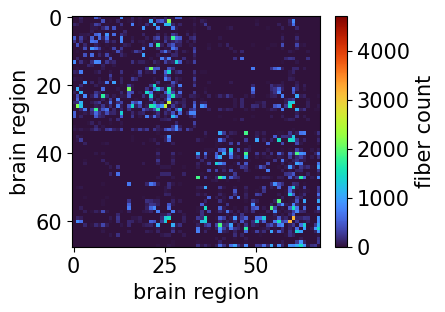

In [7]:
# check brain adjacency matrix

plt.figure(figsize=(4, 3))
plt.imshow(brain_networks.mean(0).reshape(n_rois, n_rois)*count_offset, aspect="auto", cmap="turbo")
plt.xlabel("brain region")
plt.ylabel("brain region")
plt.colorbar(label="fiber count")
plt.show()

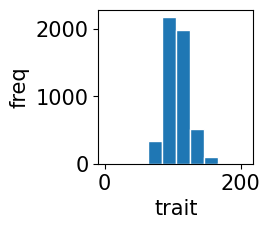

In [8]:
# check trait
plt.figure(figsize=(2,2))
plt.hist(traits, 10, edgecolor='white')
plt.xlabel('trait')
plt.ylabel('freq')
plt.show()

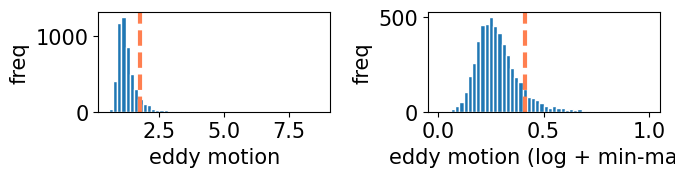

In [9]:
# check motion and rescale motion

norm_motion = min_max_standardize(np.log(motion))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,2))
ax1.hist(motion, 50, edgecolor='white')
ax1.axvline(x=np.quantile(motion, .9), color='coral', ls='dashed', lw=3)
ax1.set_xlabel('eddy motion')
ax1.set_ylabel('freq')
ax2.hist(norm_motion, 50, edgecolor='white')
ax2.axvline(x=np.quantile(norm_motion, .9), color='coral', ls='dashed', lw=3)
ax2.set_xlabel('eddy motion (log + min-max)')
ax2.set_ylabel('freq')
plt.tight_layout()
plt.show()

In [10]:
# mark subjects with big motion for later analysis

sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_motion_ids = sub_ids[norm_motion > np.quantile(norm_motion, .9)]
big_motion_mask = np.zeros_like(sub_ids)
big_motion_mask[np.isin(sub_ids, big_motion_ids)] = True
print('num of big motion subjects: {}.'.format(len(big_motion_ids)))

small_motion_ids = sub_ids[norm_motion < np.quantile(norm_motion, .1)]
small_motion_mask = np.zeros_like(sub_ids)
small_motion_mask[np.isin(sub_ids, small_motion_ids)] = True
print('num of small motion subjects: {}.'.format(len(small_motion_ids)))

num of big motion subjects: 514.
num of small motion subjects: 514.


model fitting

In [11]:
# model config

config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.1,
    beta = 1., 
    add_reg = True, y_dim = 1, 
    batch_size=64, n_epochs=500, lr=1e-5, weight_decay=0,
    device=DEVICE)

In [40]:
# prepare torch datasets for training

ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

4619 514


In [13]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

3 torch.Size([68, 68])


VAE

In [14]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay) 

In [15]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

epoch: 0 train loss: 9868.125 nll: -140.650 kl: 219.371 rmse: 12.378
epoch: 0 test loss: 5830.332 nll: -2455.910 kl: 675.934 rmse: 11.077
epoch: 5 train loss: 3880.909 nll: -2848.734 kl: 2803.538 rmse: 7.850
epoch: 5 test loss: 3836.221 nll: -2813.884 kl: 2747.877 rmse: 7.912
epoch: 10 train loss: 3606.999 nll: -2866.802 kl: 2826.390 rmse: 7.565
epoch: 10 test loss: 3572.951 nll: -2829.221 kl: 2771.917 rmse: 7.628
epoch: 15 train loss: 3360.060 nll: -2872.124 kl: 2836.745 rmse: 7.298
epoch: 15 test loss: 3332.858 nll: -2834.255 kl: 2797.043 rmse: 7.347
epoch: 20 train loss: 3125.265 nll: -2875.565 kl: 2842.142 rmse: 7.039
epoch: 20 test loss: 3106.679 nll: -2838.008 kl: 2812.308 rmse: 7.080
epoch: 25 train loss: 2901.917 nll: -2880.102 kl: 2838.828 rmse: 6.794
epoch: 25 test loss: 2890.964 nll: -2843.493 kl: 2811.357 rmse: 6.837
epoch: 30 train loss: 2686.233 nll: -2889.838 kl: 2830.326 rmse: 6.561
epoch: 30 test loss: 2681.621 nll: -2853.983 kl: 2811.018 rmse: 6.599
epoch: 35 train lo

In [16]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

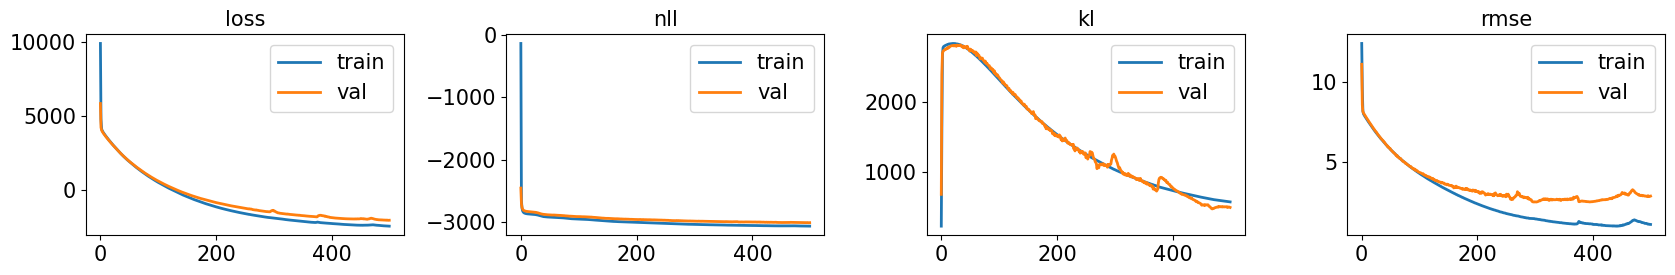

In [17]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [18]:
# torch.save(model.state_dict(), './pretrained/abcd_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/abcd_vae_pretrained.mod'))

In [58]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()

x_recon, y_pred = [], []
with torch.no_grad():
    for i in range(len(tensor_nets)):
        recon, pred, _, _ = model(
            tensor_nets[i].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device)
        )
        x_recon.append(recon.detach().cpu().numpy().reshape(n_rois, n_rois))
        y_pred.append(pred.detach().cpu().numpy())
x_recon = np.array(x_recon)
y_pred = np.array(y_pred).squeeze()

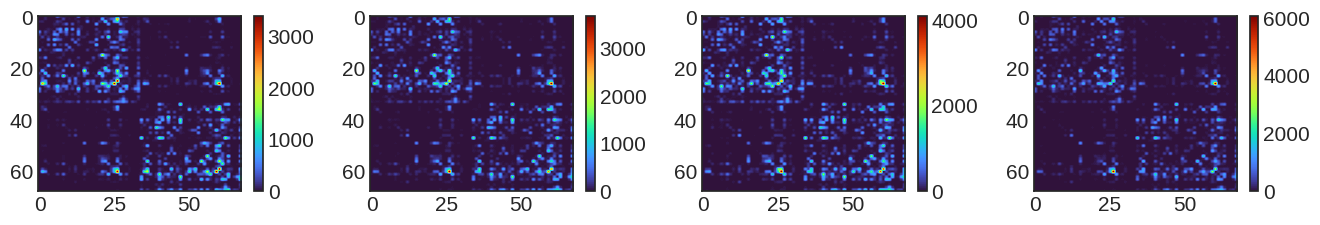

In [59]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='turbo')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [60]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_recon = x_recon[big_motion_ids]
small_motion_recon = x_recon[small_motion_ids]
diff_motion_recon= big_motion_recon.mean(0) - small_motion_recon.mean(0)

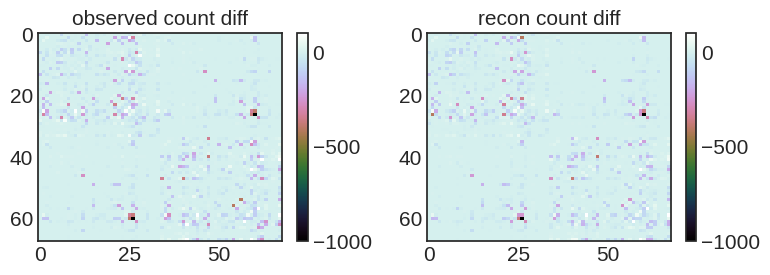

In [61]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_recon.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('recon count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

/tmp/ipykernel_68042/1152151128.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


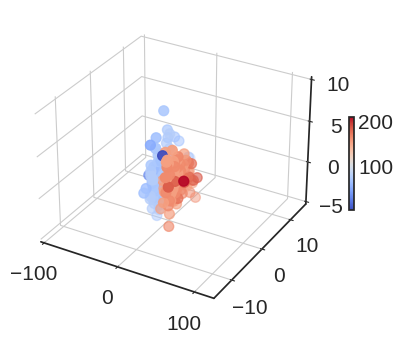

In [67]:
# viz of trait prediction

y_pred = y_pred
y_obs = traits.squeeze()

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy().squeeze()
pca = PCA(n_components=3)
pca.fit(z_mean_sub)
pca_results = pca.transform(z_mean_sub)

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'coolwarm', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
# ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
# ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
# ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.set_xlim3d(-100, 120)
ax.set_ylim3d(-15, 15)
ax.set_zlim3d(-5, 10)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

In [63]:
print(explained_variance_score(y_obs, y_pred))
print(spearmanr(y_obs.flatten(), y_pred.flatten())[0])

0.8158284954680962
0.8956937235281406


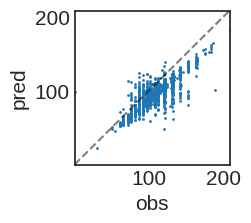

In [25]:
plt.figure(figsize=(2,2))
plt.scatter(y_obs, y_pred, s=1)
plt.xlim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.ylim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.plot([np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         [np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         ls="--", c="k", alpha=.5)
plt.xlabel("obs")
plt.ylabel("pred")
plt.show()

inv-vae

In [41]:
# model config

config = Namespace(
    n_nodes=68, 
    latent_dim=68, 
    hidden_dim=1024, 
    nuisance_dim=1,
    n_enc_layers=1, 
    n_dec_layers=3, 
    n_neighbors=32, 
    drop_out=0.1, 
    beta = 100, 
    gamma = 0.1, 
    add_reg = True, y_dim = 1, weight_decay=0,
    batch_size=64, n_epochs=500, 
    lr=1e-5, 
    device=DEVICE)

In [42]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

3 torch.Size([68, 68])


In [43]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr, weight_decay=config.weight_decay) 

In [44]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 10047.036 nll: 360.358 kl: 268.594 inv_loss: 0.566 rmse: 12.485
epoch: 0 test loss 7899.461 nll: -2225.822 kl: 850.659 inv_loss: 0.389 rmse: 11.451
epoch: 5 train loss: 522.565 nll: -2827.445 kl: 22391.896 inv_loss: 3.389 rmse: 2.690
epoch: 5 test loss 256.456 nll: -2878.333 kl: 19938.517 inv_loss: 0.532 rmse: 2.794
epoch: 10 train loss: 374.296 nll: -2851.822 kl: 22407.199 inv_loss: 2.159 rmse: 2.624
epoch: 10 test loss 220.135 nll: -2897.987 kl: 20357.959 inv_loss: 0.431 rmse: 2.722
epoch: 15 train loss: 289.743 nll: -2857.795 kl: 22330.088 inv_loss: 1.529 rmse: 2.561
epoch: 15 test loss 192.476 nll: -2903.121 kl: 20474.312 inv_loss: 0.357 rmse: 2.663
epoch: 20 train loss: 235.688 nll: -2860.247 kl: 22173.510 inv_loss: 1.155 rmse: 2.510
epoch: 20 test loss 167.572 nll: -2905.027 kl: 20635.074 inv_loss: 0.302 rmse: 2.603
epoch: 25 train loss: 191.783 nll: -2861.470 kl: 22131.938 inv_loss: 0.909 rmse: 2.450
epoch: 25 test loss 147.566 nll: -2905.957 kl: 20619.472 i

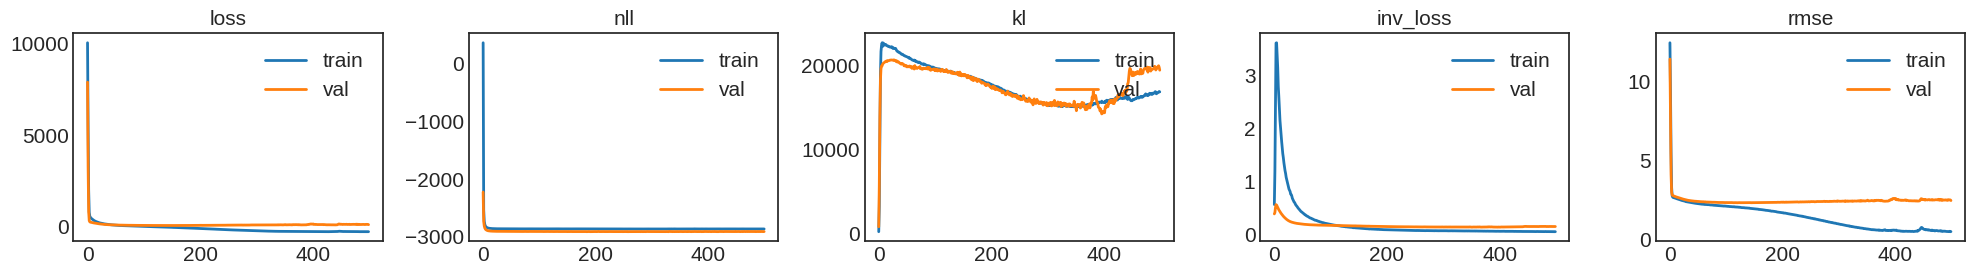

In [45]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [46]:
# torch.save(inv_model.state_dict(), './pretrained/abcd_inv_vae_pretrained.mod')
# inv_model.load_state_dict(torch.load('./pretrained/abcd_inv_vae_pretrained.mod'))

In [68]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised, y_pred = [], []
with torch.no_grad():
    for i in range(len(tensor_nets)):
        recon, pred, _, _ = inv_model(
            tensor_nets[i].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
            tensor_motion.min()*torch.tensor([1.]).to(config.device).reshape(-1,1)
        )
        x_denoised.append(recon.detach().cpu().numpy().reshape(n_rois, n_rois))
        y_pred.append(pred.detach().cpu().numpy())
x_denoised = np.array(x_denoised)
y_pred = np.array(y_pred).squeeze()

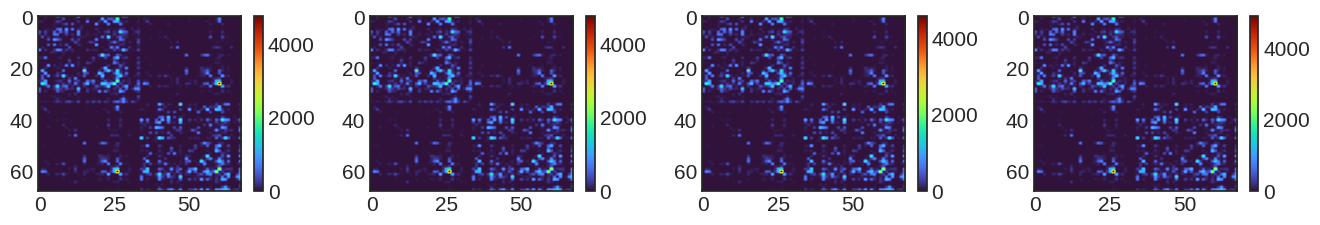

In [69]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='turbo')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [70]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_denoised = x_denoised[big_motion_ids]
small_motion_denoised = x_denoised[small_motion_ids]
diff_motion_denoised = big_motion_denoised.mean(0) - small_motion_denoised.mean(0)

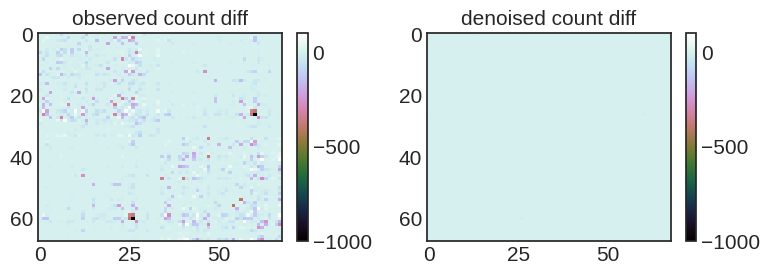

In [71]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_denoised.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('denoised count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

/tmp/ipykernel_68042/1152151128.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


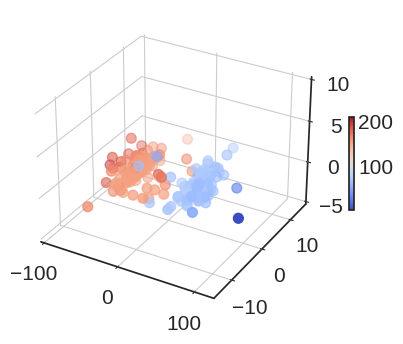

In [72]:
# viz of trait prediction

y_pred = y_pred
y_obs = traits.squeeze()

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy().squeeze()
pca = PCA(n_components=3)
pca.fit(z_mean_sub)
pca_results = pca.transform(z_mean_sub)

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'coolwarm', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
# ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
# ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
# ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.set_xlim3d(-100, 120)
ax.set_ylim3d(-15, 15)
ax.set_zlim3d(-5, 10)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

In [73]:
print(explained_variance_score(y_obs, y_pred))
print(spearmanr(y_obs.flatten(), y_pred.flatten())[0])

0.8447431278315471
0.9136969394321086


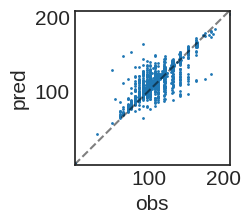

In [53]:
plt.figure(figsize=(2,2))
plt.scatter(y_obs, y_pred, s=1)
plt.xlim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.ylim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.plot([np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         [np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         ls="--", c="k", alpha=.5)
plt.xlabel("obs")
plt.ylabel("pred")
plt.show()